In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join("..")))

# Project original points to the two street networks

See also the notebook "`SF - Streets into graph`"

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.collections
import numpy as np
import bz2
import tilemapbase
import open_cp.logger
open_cp.logger.log_to_true_stdout("opencrimedata")

import opencrimedata.san_francisco
import opencrimedata.geometry
import opencrimedata.tiger_lines
import opencrimedata.network
import opencrimedata.replace

In [3]:
datadir = os.path.join("..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")

In [4]:
def gen_streets():
    filename = os.path.join(datadir, "San Francisco Basemap Street Centerlines")
    for row in opencrimedata.san_francisco.load_street_centre_lines(filename):
        if opencrimedata.san_francisco.street_layer_accept(row):
            yield row
            
proj = opencrimedata.san_francisco.projector()

def proj_street(street):
    line = np.asarray(street.line)
    return np.asarray(proj(*line.T)).T

graph, graph_names = opencrimedata.geometry.graph_from_streets(gen_streets(), proj_street)

In [5]:
def gen():
    filename = os.path.join(datadir, "SF_Police_Department_Incidents.csv.bz2")
    with bz2.open(filename, "rt", encoding="UTF8") as f:
        yield from opencrimedata.san_francisco.load(f)
        
input_points = np.asarray([ proj(*row.point) for row in gen() ])
input_points.shape

(2119901, 2)

In [6]:
agg = opencrimedata.network.NetworkProjectAggregate(graph, input_points, tolerance=10, initial_tolerance=0.5)

In [7]:
agg.projected_points.shape

(19950, 2)

In [8]:
distances = []
for pt, pi in zip(input_points, agg.to_projected_lookup):
    ppt = agg.projected_points[pi]
    distances.append(np.sqrt(np.sum((pt-ppt)**2)))
distances = np.asarray(distances)

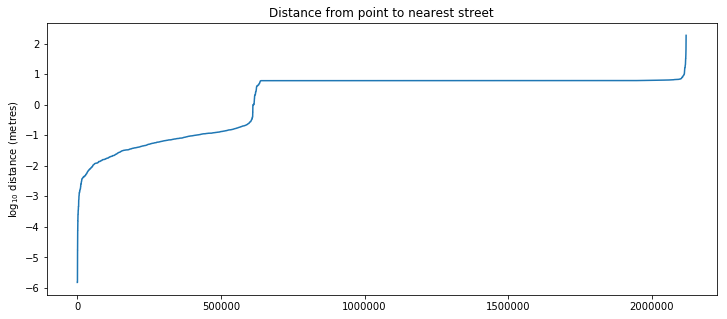

In [9]:
d = np.sort(distances)
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(np.log10(d))
ax.set_title("Distance from point to nearest street")
ax.set(ylabel="$\log_{10}$ distance (metres)")
None

In [10]:
def project(x, y):
    return tilemapbase.project(*proj(x, y, inverse=True))

wm_points = np.asarray([project(*pt) for pt in input_points])
wm_points_on_streets = []
for i in agg.to_projected_lookup:
    wm_points_on_streets.append( project(*agg.projected_points[i]) )
wm_points_on_streets = np.asarray(wm_points_on_streets)

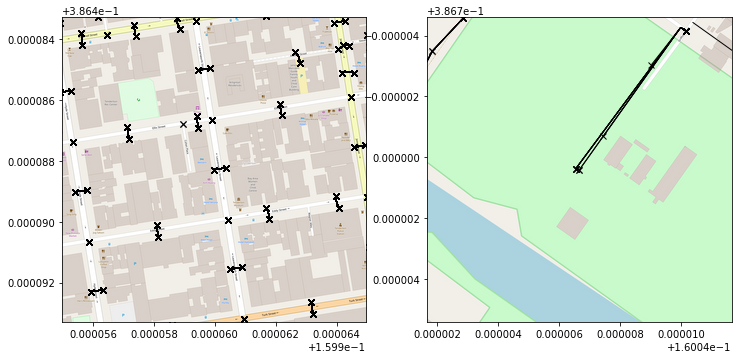

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(12,6))

i = np.where(distances > 6)[0][0]
x, y = wm_points[i]
ex = tilemapbase.Extent.from_centre(x, y, xsize=0.00001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)
plotter.plot(axes[0])

i = np.where(distances > 180)[0][0]
x, y = wm_points[i]
ex = tilemapbase.Extent.from_centre(x, y, xsize=0.00001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)
plotter.plot(axes[1])

for ax in axes:
    ax.scatter(*wm_points.T, marker="x", color="black", linewidth=1)
    lines = []
    for pt1, pt2 in zip(wm_points, wm_points_on_streets):
        lines.append((pt1, pt2))
    l = matplotlib.collections.LineCollection(lines, linewidth=1, color="black")
    ax.add_collection(l)

# Flow along the network

In [19]:
flow = opencrimedata.network.FlowPoints(graph, agg.graph_points, 50, 250)

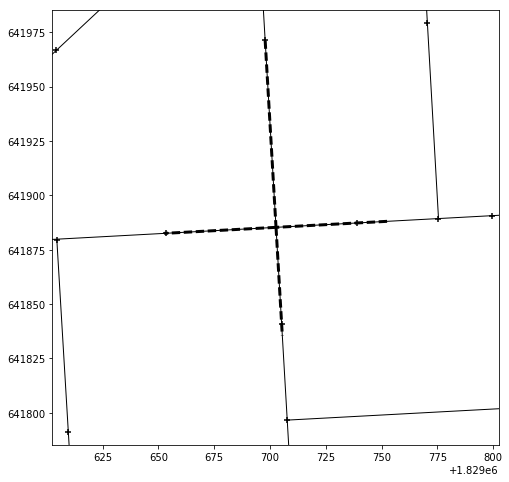

In [30]:
subset = flow.flow(4)
edge, t = flow.input_points[4]
x, y = graph.edge_to_coords(*graph.edges[edge], t)

fig, ax = plt.subplots(figsize=(8,8))

l = matplotlib.collections.LineCollection(graph.as_lines(), linewidth=1, color="black")
ax.add_collection(l)

l = matplotlib.collections.LineCollection(subset.as_lines(), linewidth=3, color="black", linestyle="--")
ax.add_collection(l)

d = 100
ax.set(xlim=[x-d, x+d], ylim=[y-d, y+d])
#ax.scatter(x,y, marker="x", color="black")

ax.scatter(*agg.projected_points.T, marker="+", color="black")
None

In [31]:
fig.savefig("sf_flow_network.png", dpi=200)

# Redistribute

In [15]:
redist = opencrimedata.network.Redistributor(graph, input_points, min_distance=50, max_distance=250)

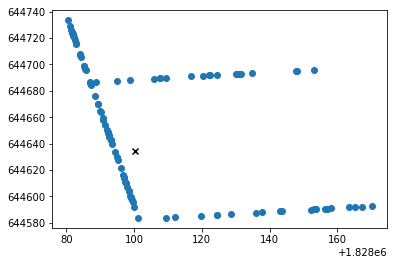

In [16]:
pts = []
for _ in range(100):
    pts.append(redist.redistribute(5))

pts = np.asarray(pts)
plt.scatter(*pts.T)

plt.scatter(*input_points[5], marker="x", color="black")

## Perform for all points

In [17]:
redist = opencrimedata.network.Redistributor(graph, input_points, min_distance=50, max_distance=250)

class MyAssign(opencrimedata.replace.AssignNew):
    def adjust(self, row):
        pt = proj(*row.point)
        pt = redist.redistribute_from_point(pt)
        return opencrimedata.san_francisco.row_with_new_position(row, *proj(*pt, inverse=True))

assign = MyAssign(gen(), seed=1234)

In [18]:
filename = os.path.join(datadir, "SF_Redist_3.csv.bz2")
with bz2.open(filename, "wt", newline="", encoding="UTF8") as f:
    opencrimedata.san_francisco.write(f, assign)

## The same with TIGER/Lines data

Seems to match a little bit better...

In [19]:
tigerdir = os.path.join("..", "..", "..", "..", "Data", "TIGER Data")
#tigerdir = os.path.join("/media", "disk", "TIGER Data")

In [20]:
tiger_lines = opencrimedata.tiger_lines.TigerLines(
    os.path.join(tigerdir, "tl_2016_06075_roads__san_francisco"),
    os.path.join(tigerdir, "tl_2016_06075_edges__san_francisco"),
    opencrimedata.san_francisco.projector())

In [21]:
graph, edge_list = tiger_lines.make_reduced_graph()

In [22]:
agg = opencrimedata.network.NetworkProjectAggregate(graph, input_points, tolerance=10, initial_tolerance=0.5)
agg.projected_points.shape

(19952, 2)

In [23]:
distances = []
for pt, pi in zip(input_points, agg.to_projected_lookup):
    ppt = agg.projected_points[pi]
    distances.append(np.sqrt(np.sum((pt-ppt)**2)))
distances = np.asarray(distances)

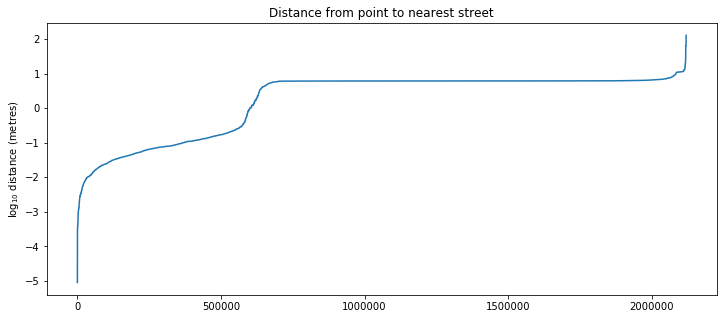

In [24]:
d = np.sort(distances)
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(np.log10(d))
ax.set_title("Distance from point to nearest street")
ax.set(ylabel="$\log_{10}$ distance (metres)")
None

In [25]:
def project(x, y):
    return tilemapbase.project(*proj(x, y, inverse=True))

wm_points = np.asarray([project(*pt) for pt in input_points])
wm_points_on_streets = []
for i in agg.to_projected_lookup:
    wm_points_on_streets.append( project(*agg.projected_points[i]) )
wm_points_on_streets = np.asarray(wm_points_on_streets)

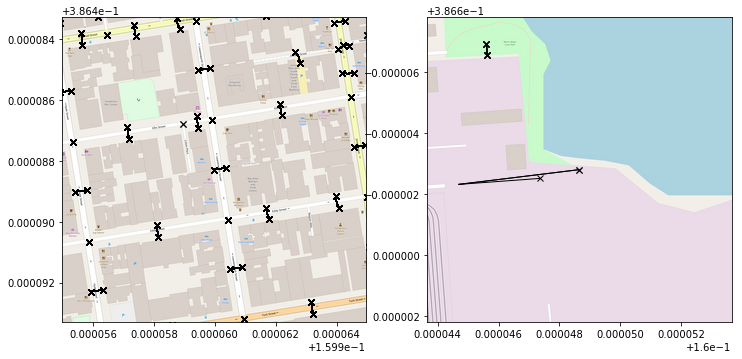

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(12,6))

i = np.where(distances > 6)[0][0]
x, y = wm_points[i]
ex = tilemapbase.Extent.from_centre(x, y, xsize=0.00001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)
plotter.plot(axes[0])

i = np.where(distances > 120)[0][0]
x, y = wm_points[i]
ex = tilemapbase.Extent.from_centre(x, y, xsize=0.00001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)
plotter.plot(axes[1])

for ax in axes:
    ax.scatter(*wm_points.T, marker="x", color="black", linewidth=1)
    lines = []
    for pt1, pt2 in zip(wm_points, wm_points_on_streets):
        lines.append((pt1, pt2))
    l = matplotlib.collections.LineCollection(lines, linewidth=1, color="black")
    ax.add_collection(l)

In [27]:
redist = opencrimedata.network.Redistributor(graph, input_points, min_distance=50, max_distance=250)

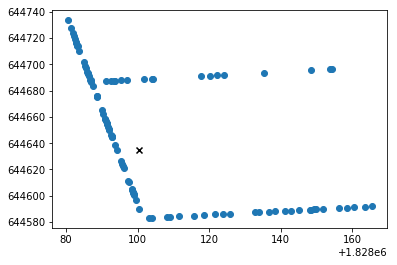

In [28]:
pts = []
for _ in range(100):
    pts.append(redist.redistribute(5))

pts = np.asarray(pts)
plt.scatter(*pts.T)

plt.scatter(*input_points[5], marker="x", color="black")

In [29]:
redist = opencrimedata.network.Redistributor(graph, input_points, min_distance=50, max_distance=250)

class MyAssign(opencrimedata.replace.AssignNew):
    def adjust(self, row):
        pt = proj(*row.point)
        pt = redist.redistribute_from_point(pt)
        return opencrimedata.san_francisco.row_with_new_position(row, *proj(*pt, inverse=True))

assign = MyAssign(gen(), seed=1234)

In [30]:
filename = os.path.join(datadir, "SF_Redist_3a.csv.bz2")
with bz2.open(filename, "wt", newline="", encoding="UTF8") as f:
    opencrimedata.san_francisco.write(f, assign)

# Some plots

In [32]:
def gen1():
    filename = os.path.join(datadir, "SF_Redist_3.csv.bz2")
    with bz2.open(filename, "rt") as f:
        yield from opencrimedata.san_francisco.load(f)

def gen2():
    filename = os.path.join(datadir, "SF_Redist_3a.csv.bz2")
    with bz2.open(filename, "rt") as f:
        yield from opencrimedata.san_francisco.load(f)

new_points1 = np.asarray([tilemapbase.project(*row.point) for row in gen1()])
new_points2 = np.asarray([tilemapbase.project(*row.point) for row in gen2()])

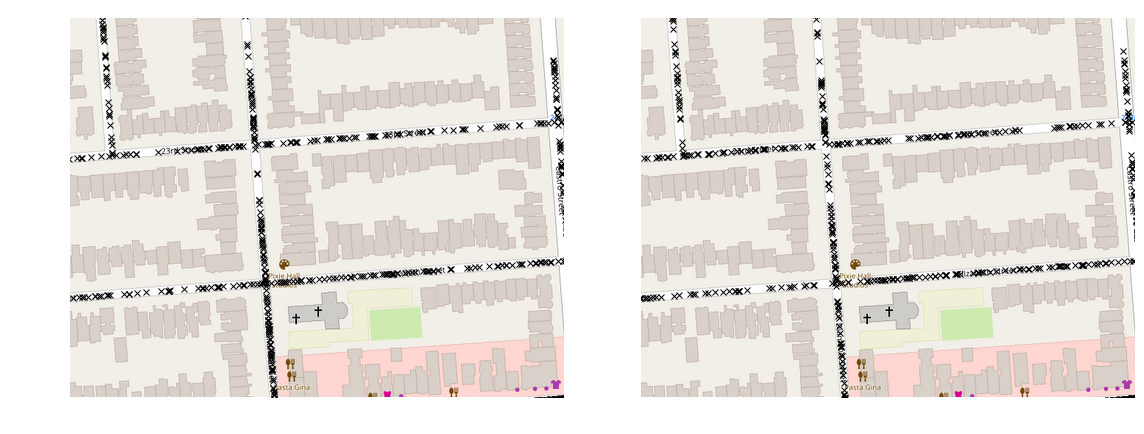

In [39]:
fig, axes = plt.subplots(ncols=2, figsize=(16,6))

ax = axes[0]
ex = tilemapbase.Extent.from_centre(0.1599, 0.3866, xsize=0.00001, aspect=1.3)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(ax)
ax.scatter(*new_points1.T, marker="x", color="black", linewidth=1)

ax = axes[1]
plotter.plot(ax)
ax.scatter(*new_points2.T, marker="x", color="black", linewidth=1)

for ax in axes:
    ax.set_axis_off()

fig.tight_layout()

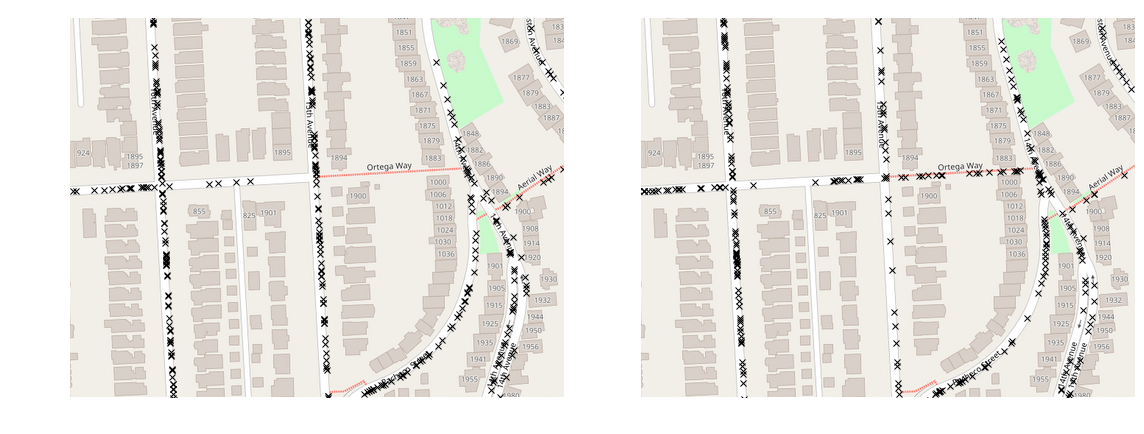

In [41]:
fig, axes = plt.subplots(ncols=2, figsize=(16,6))

ax = axes[0]
ex = tilemapbase.Extent.from_centre(0.1598, 0.3866, xsize=0.00001, aspect=1.3)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(ax)
ax.scatter(*new_points1.T, marker="x", color="black", linewidth=1)

ax = axes[1]
plotter.plot(ax)
ax.scatter(*new_points2.T, marker="x", color="black", linewidth=1)

for ax in axes:
    ax.set_axis_off()

fig.tight_layout()

In [42]:
fig.savefig("sf_redist_flow_network.png", dpi=150)